<a href="https://colab.research.google.com/github/victormurcia/VCHAMPS/blob/main/VCHAMPS_Variables_for_Measurements_and_Measurements_BP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#General utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for the progress bar
import glob,shutil,os,warnings,math,time,sys,re
from typing import List
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import timedelta

#For performing UTC normalization on datetime columns based on the STATE column
import pytz

#For Slider viz
import ipywidgets as widgets
from IPython.display import display, clear_output,HTML

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Specify the path to the desired directory
directory_path = r'/content/drive/MyDrive/VCHAMPS - Train Cleaned'

# Change the current working directory to the desired directory
os.chdir(directory_path)

# Verify the current working directory
cwd = os.getcwd()

print(f"Current working directory: {cwd}")

Current working directory: /content/drive/MyDrive/VCHAMPS - Train Cleaned


In [ ]:
measurements_df = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned-Mapped/measurements/*.parquet')
measurements_df = measurements_df.compute()

In [8]:
measurements_df = measurements_df.reset_index(drop=True)
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132
...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933


In [4]:
measurements_df['Measurement'].value_counts()

Pain                       6295488
Pulse                      5753932
Respiratory rate           4678860
Temperature                4557601
Pulse oximetry             3019414
Weight                     2091871
Height                      789963
Circumference/girth           8374
Central venous pressure       4492
Blood pressure                   5
Name: Measurement, dtype: int64

# heart_wt_admit

In [10]:
# Filter rows where 'Measurement' is 'Weight'
weight_mask = measurements_df['Measurement'] == 'Weight'

# Use drop_duplicates to keep only the first weight entry for each 'Encounter ID'
first_weight_entries = measurements_df[weight_mask].drop_duplicates(subset='Encounter ID', keep='first')

# Create a new DataFrame with 'Encounter ID' and 'Result numeric' for the first weight entries
heart_wt_admit_df = first_weight_entries[['Encounter ID', 'Result numeric']].rename(columns={'Result numeric': 'heart_wt_admit'})

# Merge the 'heart_wt_admit_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, heart_wt_admit_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000
...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797


# heart_wt_dc

In [11]:
# Filter rows where 'Measurement' is 'Weight'
weight_mask = measurements_df['Measurement'] == 'Weight'

# Use drop_duplicates to keep only the last weight entry for each 'Encounter ID'
last_weight_entries = measurements_df[weight_mask].drop_duplicates(subset='Encounter ID', keep='last')

# Create a new DataFrame with 'Encounter ID' and 'Result numeric' for the last weight entries
heart_wt_discharge_df = last_weight_entries[['Encounter ID', 'Result numeric']].rename(columns={'Result numeric': 'heart_wt_dc'})

# Merge the 'heart_wt_discharge_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, heart_wt_discharge_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033
...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935


# heart_hr_high

In [12]:
#Filter rows where 'Measurement' is 'Pulse' (heart rate)
pulse_mask = measurements_df['Measurement'] == 'Pulse'

# Use groupby to find the maximum heart rate for each 'Encounter ID'
max_heart_rate_df = measurements_df[pulse_mask].groupby('Encounter ID')['Result numeric'].max().reset_index()

# Rename the 'Result numeric' column to 'max_heart_rate'
max_heart_rate_df = max_heart_rate_df.rename(columns={'Result numeric': 'heart_hr_high'})

# Merge the 'max_heart_rate_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, max_heart_rate_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0
...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0


# heart_hr_avg

In [14]:
# Filter rows where 'Measurement' is 'Pulse' (heart rate)
pulse_mask = measurements_df['Measurement'] == 'Pulse'

# Use groupby to find the average heart rate for each 'Encounter ID'
avg_heart_rate_df = measurements_df[pulse_mask].groupby('Encounter ID')['Result numeric'].mean().reset_index()

# Rename the 'Result numeric' column to 'avg_heart_rate'
avg_heart_rate_df = avg_heart_rate_df.rename(columns={'Result numeric': 'heart_hr_avg'})

# Merge the 'avg_heart_rate_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, avg_heart_rate_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000
...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000


# id_temp_high

In [15]:
# Filter rows where 'Measurement' is 'Temperature'
temp_mask = measurements_df['Measurement'] == 'Temperature'

# Use groupby to find the maximum temperature for each 'Encounter ID'
max_temp_df = measurements_df[temp_mask].groupby('Encounter ID')['Result numeric'].max().reset_index()

# Rename the 'Result numeric' column to 'max_temperature'
max_temp_df = max_temp_df.rename(columns={'Result numeric': 'id_temp_high'})

# Merge the 'max_temp_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, max_temp_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202
...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829


# id_temp_avg

In [16]:
# Filter rows where 'Measurement' is 'Pulse' (heart rate)
temp_mask = measurements_df['Measurement'] == 'Temperature'

# Use groupby to find the average heart rate for each 'Encounter ID'
avg_temp_df = measurements_df[pulse_mask].groupby('Encounter ID')['Result numeric'].mean().reset_index()

# Rename the 'Result numeric' column to 'avg_heart_rate'
avg_temp_df = avg_temp_df.rename(columns={'Result numeric': 'id_temp_avg'})

# Merge the 'avg_heart_rate_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, avg_temp_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000


In [21]:
# Filter rows where 'Measurement' is 'Temperature'
temp_mask = measurements_df[measurements_df['Measurement'] == 'Temperature']
temp_mask

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000
5,19932,83,2002-02-14 05:43:56,Temperature,94.459305,ae96b002-0e88-4c5f-b12a-8164d932b0f1,NaN,NaN,NaN,NaN,94.459305,NaN
9,117533,59,2001-05-19 00:42:21,Temperature,97.315190,9ae01ce7-3385-4662-a897-99981071abe5,NaN,NaN,NaN,NaN,97.315190,NaN
15,85695,61,2016-07-24 11:56:42,Temperature,97.861031,b25c26c0-8a07-47cd-ae67-7ffcc447db17,NaN,NaN,NaN,NaN,97.861031,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
27199986,165778,68,2021-02-22 12:42:20,Temperature,98.638944,47746d1c-0de0-524a-8ddd-bc3b3fc015ac,214.549925,217.207596,134.0,83.863014,103.477150,83.863014
27199989,133461,60,2008-12-07 21:05:35,Temperature,99.000000,bc39c140-7cc8-4a7c-8455-cb9fb00ff056,NaN,NaN,NaN,NaN,99.000000,NaN
27199990,7805,75,2019-05-24 13:38:20,Temperature,102.313343,b295e67f-c8f3-59e3-a1a8-cb78b5e51f75,NaN,NaN,NaN,NaN,102.313343,NaN
27199993,141076,82,2007-12-14 14:17:50,Temperature,93.455488,d755df56-181a-4b12-a59c-ffa047bccbad,NaN,NaN,NaN,NaN,93.455488,NaN


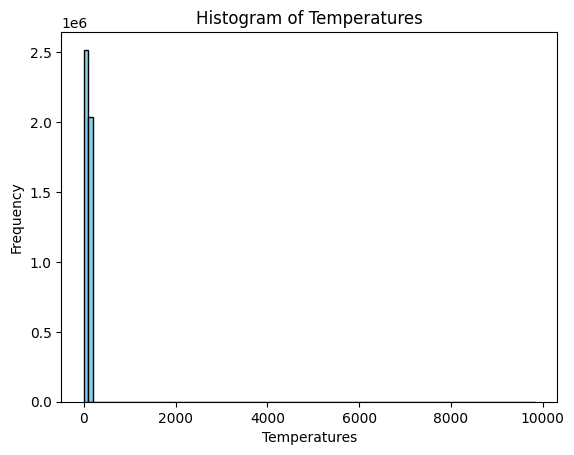

In [24]:
# Plot the histogram
plt.hist(temp_mask['Result numeric'], bins=100, color='skyblue', edgecolor='black')
# Add labels and title
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.title('Histogram of Temperatures')
plt.show()

# id_temp_high

In [27]:
#I'm not sure what the temperature units are. Will assume that they are in Fahrenheit
# Filter rows where 'Measurement' is 'Temperature'
temp_mask = measurements_df['Measurement'] == 'Temperature'

# Use groupby to find the maximum temperature for each 'Encounter ID'
max_temp_df = measurements_df[temp_mask].groupby('Encounter ID')['Result numeric'].max().reset_index()

# Create the 'fever' column and set it to 1 if temperature is greater than 100.4, else set to 0
max_temp_df['id_temp_up'] = max_temp_df['Result numeric'].apply(lambda x: 1 if x > 100.4 else 0)

# Merge the 'fever' column back into the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, max_temp_df[['Encounter ID', 'id_temp_up']], on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0


# resp_rr_avg

In [28]:
# Filter rows where 'Measurement' is 'Respiratory rate'
resp_rate_mask = measurements_df['Measurement'] == 'Respiratory rate'

# Use groupby to find the average respiratory rate for each 'Encounter ID'
resp_rr_avg_df = measurements_df[resp_rate_mask].groupby('Encounter ID')['Result numeric'].mean().reset_index()

# Rename the 'Result numeric' column to 'resp_rr_avg'
resp_rr_avg_df = resp_rr_avg_df.rename(columns={'Result numeric': 'resp_rr_avg'})

# Merge the 'resp_rr_avg_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, resp_rr_avg_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up,resp_rr_avg
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0,18.500000
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0,NaN
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0,17.000000
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0,16.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0,17.509804
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0,21.592593
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0,18.750000


# resp_rr_high

In [29]:
# Use groupby to find the maximum respiratory rate for each 'Encounter ID'
resp_rr_high_df = measurements_df[resp_rate_mask].groupby('Encounter ID')['Result numeric'].max().reset_index()

# Rename the 'Result numeric' column to 'resp_rr_high'
resp_rr_high_df = resp_rr_high_df.rename(columns={'Result numeric': 'resp_rr_high'})

# Merge the 'resp_rr_high_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, resp_rr_high_df, on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up,resp_rr_avg,resp_rr_high
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0,18.500000,21.0
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0,NaN,NaN
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0,17.000000,18.0
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0,16.750000,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0,17.509804,23.0
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0,21.592593,35.0
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0,18.750000,21.0


# discharge_hr

In [30]:
# Filter rows where 'Measurement' is 'Pulse'
heart_rate_mask = measurements_df['Measurement'] == 'Pulse'

# Sort the data by 'Measurement date' in descending order within each 'Encounter ID'
sorted_measurements_df = measurements_df[heart_rate_mask].sort_values(by='Measurement date', ascending=False)

# Use drop_duplicates to keep only the first row (latest measurement) for each 'Encounter ID'
final_heart_rate_df = sorted_measurements_df.drop_duplicates(subset='Encounter ID', keep='first')

# Rename the 'Result numeric' column to 'final_heart_rate'
final_heart_rate_df = final_heart_rate_df.rename(columns={'Result numeric': 'discharge_hr'})

# Merge the 'final_heart_rate_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, final_heart_rate_df[['Encounter ID', 'discharge_hr']], on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up,resp_rr_avg,resp_rr_high,discharge_hr
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0,NaN,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0,18.500000,21.0,76.0
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0,NaN,NaN,66.0
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0,17.000000,18.0,62.0
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0,16.750000,18.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0,17.509804,23.0,58.0
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0,21.592593,35.0,125.0
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0,18.750000,21.0,70.0


# discharge_blood_pressure

In [31]:
# Filter rows where 'Measurement' is 'Blood pressure'
blood_pressure_mask = measurements_df['Measurement'] == 'Blood pressure'

# Sort the data by 'Measurement date' in descending order within each 'Encounter ID'
sorted_measurements_df = measurements_df[blood_pressure_mask].sort_values(by='Measurement date', ascending=False)

# Use drop_duplicates to keep only the first row (latest measurement) for each 'Encounter ID'
discharge_blood_pressure_df = sorted_measurements_df.drop_duplicates(subset='Encounter ID', keep='first')

# Rename the 'Result numeric' column to 'discharge_blood_pressure'
discharge_blood_pressure_df = discharge_blood_pressure_df.rename(columns={'Result numeric': 'discharge_blood_pressure'})

# Merge the 'discharge_blood_pressure_df' DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, discharge_blood_pressure_df[['Encounter ID', 'discharge_blood_pressure']], on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up,resp_rr_avg,resp_rr_high,discharge_hr,discharge_blood_pressure
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0,NaN,NaN,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0,18.500000,21.0,76.0,NaN
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0,NaN,NaN,66.0,NaN
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0,17.000000,18.0,62.0,NaN
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0,16.750000,18.0,83.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0,17.509804,23.0,58.0,NaN
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0,21.592593,35.0,125.0,NaN
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0,18.750000,21.0,70.0,NaN


In [32]:
measurements_df.to_parquet('/content/drive/MyDrive/VCHAMPS - Final Train Data/measurements.parquet')

# bmi

In [37]:
# Create masks for 'Weight' and 'Height' measurements
weight_mask = measurements_df['Measurement'] == 'Weight'
height_mask = measurements_df['Measurement'] == 'Height'

# Get the first weight entry for each 'Encounter ID'
first_weight_df = measurements_df[weight_mask].groupby('Encounter ID').first().reset_index()

# Get the first height entry for each 'Encounter ID'
first_height_df = measurements_df[height_mask].groupby('Encounter ID').first().reset_index()

# Calculate BMI using the formula: BMI = weight / (height)^2 * 703
first_weight_df['BMI'] = first_weight_df['Result numeric'] / (first_height_df['Result numeric'] ** 2) * 703
first_weight_df

# Merge the first_weight_df DataFrame with the original DataFrame on 'Encounter ID'
measurements_df = pd.merge(measurements_df, first_weight_df[['Encounter ID', 'BMI']], on='Encounter ID', how='left')
measurements_df

,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Encounter ID,heart_wt_admit,heart_wt_dc,heart_hr_high,heart_hr_avg,id_temp_high,id_temp_avg,id_temp_up,resp_rr_avg,resp_rr_high,discharge_hr,discharge_blood_pressure,BMI
0,1,59,2003-05-21 00:27:01,Temperature,95.804066,0ca96b3d-9cca-461d-ba94-b1e8fe8ecfff,NaN,NaN,NaN,NaN,95.804066,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,9713,68,2017-08-17 18:10:50,Pulse oximetry,88.000000,2395b56a-b7db-5a4b-869f-5ae3bcc11ee6,NaN,NaN,88.0,83.750000,101.642561,83.750000,1.0,18.500000,21.0,76.0,NaN,NaN
2,97124,72,2019-02-09 17:56:52,Pulse,66.000000,a06f4802-c63a-562f-9160-4a65241f4d7e,241.440850,241.440850,66.0,66.000000,96.582804,66.000000,0.0,NaN,NaN,66.0,NaN,NaN
3,107718,63,2020-12-16 02:10:45,Temperature,95.979629,e158e91c-6384-5b83-8178-dceb8893a91c,253.359525,254.649458,68.0,63.500000,95.979629,63.500000,0.0,17.000000,18.0,62.0,NaN,NaN
4,96334,72,2016-01-09 06:23:49,Height,68.793928,8f78627d-d7da-5da5-bdf8-63bdc3d9e132,126.000000,119.626033,93.0,80.800000,99.667202,80.800000,0.0,16.750000,18.0,83.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199995,56828,52,2011-10-30 16:34:29,Pulse,64.000000,22babbdd-2398-5d74-80b9-d93f846b018f,188.290813,216.466102,149.0,73.090909,103.000000,73.090909,1.0,17.509804,23.0,58.0,NaN,21.756812
27199996,128003,70,2012-02-24 14:35:20,Pulse,83.000000,6d130e56-fc0b-5f5e-8897-0dc115483bb6,222.310952,241.781791,139.0,101.516129,101.409013,101.516129,1.0,21.592593,35.0,125.0,NaN,NaN
27199997,110343,69,2011-08-30 22:40:09,Pulse oximetry,90.000000,66ac08ad-edd3-4e67-b875-efee1b188297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27199998,47388,70,2010-05-13 15:22:55,Respiratory rate,18.000000,7abb124e-78f9-5eab-8477-8b9386928933,157.357797,158.690935,80.0,66.750000,101.122829,66.750000,1.0,18.750000,21.0,70.0,NaN,NaN


In [38]:
measurements_df.to_parquet('/content/drive/MyDrive/VCHAMPS - Final Train Data/measurements.parquet')

In [39]:
#Clear all variables
%reset -f

In [43]:
measurements_bp_df = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned-Mapped/measurements_bp/*.parquet')
measurements_bp_df = measurements_bp_df.compute()
measurements_bp_df

,Internalpatientid,Age at measurement bp,Measurement date,Diastolic bp,Systolic bp,Encounter ID
0,83189,54,2005-02-28 05:05:34,79,120,7f635061-7d06-532d-b462-3bc8a46e67b6
1,61042,67,2018-03-27 19:03:44,62,113,d8b5ec41-4e49-593c-9226-0de174393e8e
2,55393,52,2015-11-04 04:24:23,83,125,5743ef1c-5dc2-5e45-ad6f-2c26e74f6402
3,45845,54,2017-07-02 13:54:24,84,153,790a7d0f-7de1-5f8e-a41c-ee3197ce254e
4,103234,73,2017-04-08 10:43:34,71,151,b05eca39-4261-4f51-9646-010cbac1b5d6
...,...,...,...,...,...,...
9995,130060,78,2011-08-14 13:55:25,85,181,3d00e426-3f95-53b6-b9b4-72ae70be56f0
9996,144793,52,2018-01-11 22:44:02,72,105,d761ab81-f7f9-4aad-ae62-db7e65da9626
9997,62421,67,2007-01-24 04:18:55,79,144,ebcb336a-f816-4e01-b856-cdbeeee41cef
9998,141195,61,2007-04-24 16:21:11,73,136,91d4f847-f532-4964-a229-5afc9fccd4f1


Mean arterial blood pressure

In [45]:
# Calculate mean arterial blood pressure (MAP) using the formula: ⅔ diastolic BP + ⅓ systolic BP
measurements_bp_df['map'] = (2/3) * measurements_bp_df['Diastolic bp'] + (1/3) * measurements_bp_df['Systolic bp']
measurements_bp_df

,Internalpatientid,Age at measurement bp,Measurement date,Diastolic bp,Systolic bp,Encounter ID,map
0,83189,54,2005-02-28 05:05:34,79,120,7f635061-7d06-532d-b462-3bc8a46e67b6,92.666667
1,61042,67,2018-03-27 19:03:44,62,113,d8b5ec41-4e49-593c-9226-0de174393e8e,79.000000
2,55393,52,2015-11-04 04:24:23,83,125,5743ef1c-5dc2-5e45-ad6f-2c26e74f6402,97.000000
3,45845,54,2017-07-02 13:54:24,84,153,790a7d0f-7de1-5f8e-a41c-ee3197ce254e,107.000000
4,103234,73,2017-04-08 10:43:34,71,151,b05eca39-4261-4f51-9646-010cbac1b5d6,97.666667
...,...,...,...,...,...,...,...
9995,130060,78,2011-08-14 13:55:25,85,181,3d00e426-3f95-53b6-b9b4-72ae70be56f0,117.000000
9996,144793,52,2018-01-11 22:44:02,72,105,d761ab81-f7f9-4aad-ae62-db7e65da9626,83.000000
9997,62421,67,2007-01-24 04:18:55,79,144,ebcb336a-f816-4e01-b856-cdbeeee41cef,100.666667
9998,141195,61,2007-04-24 16:21:11,73,136,91d4f847-f532-4964-a229-5afc9fccd4f1,94.000000


# average map

In [47]:
# Group the DataFrame by 'Encounter ID' and calculate the average MAP for each encounter
average_map_df = measurements_bp_df.groupby('Encounter ID')['map'].mean().reset_index()
# Merge the average_map_df DataFrame back into the original measurements_blood_pressure DataFrame
measurements_bp_df = pd.merge(measurements_bp_df, average_map_df, on='Encounter ID', suffixes=('', '_avg'))
measurements_bp_df

,Internalpatientid,Age at measurement bp,Measurement date,Diastolic bp,Systolic bp,Encounter ID,map,map_avg
0,83189,54,2005-02-28 05:05:34,79,120,7f635061-7d06-532d-b462-3bc8a46e67b6,92.666667,81.884354
1,83189,54,2005-02-25 10:10:53,72,118,7f635061-7d06-532d-b462-3bc8a46e67b6,87.333333,81.884354
2,83189,54,2005-03-22 06:27:11,67,110,7f635061-7d06-532d-b462-3bc8a46e67b6,81.333333,81.884354
3,83189,54,2005-03-29 16:49:40,63,106,7f635061-7d06-532d-b462-3bc8a46e67b6,77.333333,81.884354
4,83189,54,2005-03-04 17:19:07,63,109,7f635061-7d06-532d-b462-3bc8a46e67b6,78.333333,81.884354
...,...,...,...,...,...,...,...,...
9999995,73313,64,2010-11-16 12:09:13,63,132,de85b144-0bbd-4423-85b3-08757a5e79e8,86.000000,86.000000
9999996,144793,52,2018-01-11 22:44:02,72,105,d761ab81-f7f9-4aad-ae62-db7e65da9626,83.000000,83.000000
9999997,62421,67,2007-01-24 04:18:55,79,144,ebcb336a-f816-4e01-b856-cdbeeee41cef,100.666667,100.666667
9999998,141195,61,2007-04-24 16:21:11,73,136,91d4f847-f532-4964-a229-5afc9fccd4f1,94.000000,94.000000


# map_low

In [49]:
# Group the DataFrame by 'Encounter ID' and calculate the minimum MAP for each encounter
lowest_map_df = measurements_bp_df.groupby('Encounter ID')['map'].min().reset_index()
measurements_bp_df = pd.merge(measurements_bp_df, lowest_map_df, on='Encounter ID', suffixes=('', '_low'))
measurements_bp_df

,Internalpatientid,Age at measurement bp,Measurement date,Diastolic bp,Systolic bp,Encounter ID,map,map_avg,map_low
0,83189,54,2005-02-28 05:05:34,79,120,7f635061-7d06-532d-b462-3bc8a46e67b6,92.666667,81.884354,65.333333
1,83189,54,2005-02-25 10:10:53,72,118,7f635061-7d06-532d-b462-3bc8a46e67b6,87.333333,81.884354,65.333333
2,83189,54,2005-03-22 06:27:11,67,110,7f635061-7d06-532d-b462-3bc8a46e67b6,81.333333,81.884354,65.333333
3,83189,54,2005-03-29 16:49:40,63,106,7f635061-7d06-532d-b462-3bc8a46e67b6,77.333333,81.884354,65.333333
4,83189,54,2005-03-04 17:19:07,63,109,7f635061-7d06-532d-b462-3bc8a46e67b6,78.333333,81.884354,65.333333
...,...,...,...,...,...,...,...,...,...
9999995,73313,64,2010-11-16 12:09:13,63,132,de85b144-0bbd-4423-85b3-08757a5e79e8,86.000000,86.000000,86.000000
9999996,144793,52,2018-01-11 22:44:02,72,105,d761ab81-f7f9-4aad-ae62-db7e65da9626,83.000000,83.000000,83.000000
9999997,62421,67,2007-01-24 04:18:55,79,144,ebcb336a-f816-4e01-b856-cdbeeee41cef,100.666667,100.666667,100.666667
9999998,141195,61,2007-04-24 16:21:11,73,136,91d4f847-f532-4964-a229-5afc9fccd4f1,94.000000,94.000000,94.000000


In [50]:
measurements_bp_df.to_parquet('/content/drive/MyDrive/VCHAMPS - Final Train Data/measurements_bp.parquet')